In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.6 MB/s eta 0:00:00


In [2]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 11.7 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8

In [1]:
import copy
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
df = pd.read_csv("final_data2.csv")
df = df.sort_values('date')
df.head()

,gvkey,month,year,date,ggroup,gsubind,conm,dpr,PEG_trailing,bm,...,Currency in Circulation,10-Year Treasury Constant Maturity Minus Federal Funds Rate,Rent Inflation Rate,US GDP Growth Rate,trt1m,risk1y,trt1y,risk2y,trt6m,risk1m
0,1013,12,1997,1998/1/31,Technology Hardware & Equipment,45201020,ADC TELECOMMUNICATIONS INC,0.000000,-0.072822,-0.709247,...,-0.001059,-2.0,0.24939,0.011473,-54.3401,NaN,-16.766539,NaN,-12.500010,0.289374
86340,9351,12,1997,1998/1/31,Insurance,40301040,SAFECO CORP,0.000000,-0.098360,1.214410,...,-0.001059,0.0,0.24939,0.011473,3.0913,NaN,-9.371368,NaN,-5.726436,0.001323
86468,9357,12,1997,1998/1/31,Commercial & Professional Services,20201050,SAFETY-KLEEN CORP-OLD,-0.057466,0.286446,0.017754,...,-0.001059,-2.0,0.24939,0.011473,-5.2374,NaN,NaN,NaN,NaN,0.002200
86472,9359,12,1997,1998/1/31,Food & Staples Retailing,30101030,SAFEWAY INC,0.000000,0.000000,0.000000,...,-0.001059,-2.0,0.24939,0.011473,5.0387,NaN,92.687423,NaN,28.656101,0.003120
5290,1478,12,1997,1998/1/31,"Pharmaceuticals, Biotechnology & Life Sciences",35202010,WYETH,-0.013251,0.000000,0.000000,...,-0.001059,0.0,0.24939,0.011473,24.7542,NaN,49.987927,NaN,36.519336,0.064013


In [3]:
df.reset_index(inplace=True)
df.drop(columns=['index', 'risk1y', 'trt1y', 'risk2y', 'trt6m', 'trt1m'],inplace=True)

In [4]:
df["risk1m"] = df["risk1m"].clip(upper = 50,lower =-50)

In [5]:
df["risk1m"] = df.groupby('date')["risk1m"].transform(lambda x: (x - x.mean()) / x.std())

In [6]:
df["time_idx"] = df["year"] * 12 + df["month"]
df["time_idx"] -= df["time_idx"].min()
df['time_idx'] = df['time_idx'].astype(int)
#data = data.set_index("date")
#data = data.resample("M").last()  # resample to monthly frequency
#data = data.reset_index()
df.drop(columns=['month','year','ggroup','gsubind','conm', 'int_totdebt', 'cash_conversion', 'prccm', 'prchm', 'prclm', 'Market_Cap', 'Market_Cap_missing'],inplace=True)
df = df.dropna(axis=0)

#train_data = data[data['date'] <= '2018-01-01']
#test_data = data[data['date'] >= '2018-01-01']

data_prior2014=df[df['date']<='2014-01-01']
val_data_2 =df[(df['date']>='2014-01-01')&(df['date']<='2018-01-01')]
test_data =df[df['date']>='2016-01-01']


In [7]:
list_gvkey=data_prior2014['gvkey'].unique()
df_gvkey=pd.DataFrame({'gvkey':list_gvkey})
train_set=df_gvkey.sample(n=int(len(df_gvkey)*0.6))
valid_set=df_gvkey[(df_gvkey['gvkey'].isin(list(train_set['gvkey']))==False)]

train_data =data_prior2014[data_prior2014['gvkey'].isin(train_set['gvkey'])]
val_data_1 =data_prior2014[data_prior2014['gvkey'].isin(valid_set['gvkey'])]

In [8]:
train_data.sort_values(by=['gvkey','date'],inplace=True)
train_data.reset_index(inplace=True)
train_data.drop(columns='index',inplace=True)

In [9]:
val_data_1.sort_values(by=['gvkey','date'],inplace=True)
val_data_1.reset_index(inplace=True)
val_data_1.drop(columns='index',inplace=True)

In [10]:
val_data_2.sort_values(by=['gvkey','date'],inplace=True)
val_data_2.reset_index(inplace=True)
val_data_2.drop(columns='index',inplace=True)

In [11]:
test_data.sort_values(by=['gvkey','date'],inplace=True)
test_data.reset_index(inplace=True)
test_data.drop(columns='index',inplace=True)

In [12]:
list_to_remove = ['gvkey', 'date','time_idx']
col_list = set(list(df.columns)) - set(list_to_remove)
col_list = list(col_list)

In [13]:
val_data_1

,gvkey,date,dpr,PEG_trailing,bm,CAPEI,divyield,evm,pcf,pe_exi,...,US Population,Bank Prime Loan Rate,M2,"Bank Credit, All Commercial Banks",Currency in Circulation,10-Year Treasury Constant Maturity Minus Federal Funds Rate,Rent Inflation Rate,US GDP Growth Rate,risk1m,time_idx
0,1013,1998/1/31,0.0,-0.072822,-0.709247,0.000000,0.0,0.378444,0.000000,0.000000,...,0.000849,0.0,-0.008832,-0.001099,-0.001059,-2.000000,0.249390,0.011473,11.917102,0
1,1013,1998/10/31,0.0,-0.185779,-0.682509,0.000000,0.0,0.071888,0.000000,0.000000,...,0.001015,0.0,-0.004558,0.005219,0.008474,0.014286,-0.002884,0.018955,-0.330491,9
2,1013,1998/11/30,0.0,-0.174469,-0.673310,0.000000,0.0,0.070528,0.000000,0.000000,...,0.000945,0.0,0.003484,0.001787,0.010424,11.333333,-0.002875,0.018955,1.120403,10
3,1013,1998/12/31,0.0,-0.151566,-0.768650,0.000000,0.0,0.030695,0.000000,0.000000,...,0.000923,0.0,-0.000863,0.002935,0.016943,-4.866667,-0.202294,0.018955,-0.171847,11
4,1013,1998/2/28,0.0,-0.234694,-0.686603,0.000000,0.0,0.381725,0.000000,0.000000,...,0.000768,0.0,-0.001078,0.002307,-0.006808,0.250000,-0.002361,0.011473,3.317932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55696,187697,2013/5/31,0.0,0.494419,0.000000,0.115577,0.0,0.000000,0.429614,-0.020800,...,0.000613,0.0,-0.003008,-0.000745,0.005605,0.000000,0.518578,0.004240,-0.177614,184
55697,187697,2013/6/30,0.0,0.470979,0.000000,-0.027672,0.0,0.000000,0.547954,0.065094,...,0.000647,0.0,-0.010615,-0.001703,0.003938,0.000000,-0.185686,0.004240,3.455955,185
55698,187697,2013/7/31,0.0,0.496635,0.000000,-0.017525,0.0,0.000000,0.739961,0.102246,...,0.000700,0.0,-0.001229,0.000395,0.005790,0.000000,-0.314681,0.012666,-0.393869,186
55699,187697,2013/8/31,0.0,0.486851,0.000000,-0.017535,0.0,0.000000,0.761875,0.096907,...,0.000760,0.0,-0.002834,-0.000338,0.001853,0.000000,1.304266,0.012666,1.039489,187


In [14]:
# Set hyperparameters
n_epochs = 50 # maybe reduce it 
batch_size = 32
n_time_steps = 24 # make it bigger between 24 to 48 
n_features = 147 # select few important features 
hidden_layer_size = 128
n_predictions = 6 # bettween 6 to 12 


# Define time series dataset
training_data = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="risk1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list, # filter it 
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)


In [15]:

testing_data = TimeSeriesDataSet(
    test_data,
    time_idx="time_idx",
    target="risk1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list,
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)

testing_data2 = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="risk1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list,
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)


In [16]:

validation_data_1 = TimeSeriesDataSet(
    val_data_1,
    time_idx="time_idx",
    target="risk1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list,
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)

validation_data_2 = TimeSeriesDataSet(
    val_data_2,
    time_idx="time_idx",
    target="risk1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list,
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128

train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader_1 = validation_data_1.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
val_dataloader_2 = validation_data_2.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
testing_dataloader = testing_data.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
testing_dataloader2 = testing_data2.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [72]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training_data,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate, try lower value 
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
d:\Python\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 113.3k


In [19]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    auto_select_gpus=True,
    accelerator='gpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training_data,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

d:\Python\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:578: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 113.3k


In [19]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders= val_dataloader_1,
) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 2.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 98.5 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
from sklearn.metrics import mean_squared_error
import pandas as pd
 
def compute_averages(df):
    num_rows, num_cols = df.shape
    output = []
 
    for i in range(num_rows + num_cols - 1):
        total = 0
        count = 0
 
        for j in range(max(0, i - num_cols + 1), min(i + 1, num_rows)):
            total += df.iloc[j, i - j]
            count += 1
 
        output.append(total / count)
 
    return output

def get_predict(model, dataloader, timeseires_dataset, dataset):
    predictions, index1 = model.predict(dataloader, return_index=True)
    predictions_array = predictions.numpy()
    df_predictions = pd.DataFrame(predictions_array, columns=['predictions t+{}'.format(i) for i in range(predictions_array.shape[1])])
    mean_results = compute_averages(df_predictions)

    predictions_array2 = model.output_transformer.inverse_transform(predictions).numpy()
    df_predictions2 = pd.DataFrame(predictions_array2, columns=['predictions t+{}'.format(i) for i in range(predictions_array2.shape[1])])
    mean_results2 = compute_averages(df_predictions2)

    index = timeseires_dataset.decoded_index.copy()
    index['prediction'] = mean_results[:-5]
    index['prediction_decode'] = mean_results2[:-5]

    new_data = pd.merge(dataset, index, left_on=['gvkey', 'time_idx'], right_on=['gvkey', 'time_idx_first_prediction'], how='left')
    new_data = new_data.drop(columns=['time_idx_first_prediction', 'time_idx_first', 'time_idx_last'])
    # select the last 5 rows of the "predict" column using .iloc
    new_data.iloc[-5:, -2] = mean_results[-5:]
    new_data.iloc[-5:, -1] = mean_results2[-5:]

    final_data = new_data[new_data['date']>='2018-01-01']
    final_data = final_data.dropna()
    final_data.sort_values(by=['gvkey','date'],inplace=True)
    final_data.reset_index(inplace=True)
    final_data.drop(columns=['index'],inplace=True)

    per_period_median_prediction = final_data.groupby('date')['prediction_decode'].apply(lambda x: np.percentile(x, 50)).reset_index()
    per_period_median_prediction = per_period_median_prediction.rename(columns={'prediction_decode':"predict_median"})
    per_period_median_actual = final_data.groupby('date')['risk1m'].apply(lambda x: np.percentile(x, 50)).reset_index()
    per_period_median_actual = per_period_median_actual.rename(columns={'risk1m':"actual_median"})
    data_roc = final_data.merge(per_period_median_prediction, on='date')
    data_roc = data_roc.merge(per_period_median_actual, on='date')
    data_roc['prediction_decode_fix'] = data_roc['prediction_decode'] - data_roc['predict_median'] + data_roc['actual_median']
    data_roc = data_roc.drop(columns=['predict_median', 'actual_median'])

    print("mse", mean_squared_error(data_roc['prediction'],data_roc['risk1m']))
    return data_roc

In [21]:
final_data = get_predict(tft, testing_dataloader2, testing_data2, df)
final_data

mse 0.20134032589604123


,gvkey,date,dpr,PEG_trailing,bm,CAPEI,divyield,evm,pcf,pe_exi,...,"Bank Credit, All Commercial Banks",Currency in Circulation,10-Year Treasury Constant Maturity Minus Federal Funds Rate,Rent Inflation Rate,US GDP Growth Rate,risk1m,time_idx,prediction,prediction_decode,prediction_decode_fix
0,1045,2018/1/31,0.000000,0.000000,0.000000,0.000000,-0.638283,0.000000,0.000000,0.000000,...,0.000149,0.004236,0.053435,-0.087386,0.013106,0.000051,240,0.003301,0.000233,0.001884
1,1075,2018/1/31,0.000000,0.000000,0.927742,-0.002988,0.565653,-0.067657,-0.252905,0.000000,...,0.000149,0.004236,0.000000,-0.087386,0.013106,0.010900,240,0.000844,0.000232,0.001883
2,1078,2018/1/31,0.006169,-0.186223,0.000000,0.156408,0.000000,0.000000,0.153418,0.355412,...,0.000149,0.004236,0.053435,-0.087386,0.013106,0.001843,240,0.000611,0.000232,0.001883
3,1161,2018/1/31,0.000000,-0.376500,-0.822953,-0.175380,0.000000,0.276494,-3.725378,0.000000,...,0.000149,0.004236,0.000000,0.000000,0.000000,0.081462,240,0.019170,0.000242,0.001893
4,1177,2018/1/31,-0.112942,5.055414,-0.294288,0.024273,-0.473473,-0.065899,1.146568,0.159627,...,0.000149,0.004236,0.053435,-0.087386,0.013106,0.000162,240,0.001819,0.000233,0.001883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25213,10035,2022/1/31,-0.069822,0.583847,0.778903,-0.020292,0.328110,-0.175117,-0.619378,-0.235337,...,0.000549,0.004371,0.005882,0.434208,0.016073,0.003178,288,0.003525,0.000234,0.003178
25214,17874,2022/1/31,0.000000,-0.514286,0.135492,0.082959,0.000000,-0.098105,-0.227753,0.264785,...,0.000549,0.004371,0.005882,0.434208,0.016073,0.000734,288,0.003991,0.000234,0.003178
25215,28070,2022/1/31,0.000000,-0.499837,0.403580,-0.006272,-0.698229,-0.219666,-0.345254,-0.305476,...,0.000549,0.004371,0.005882,0.434208,0.016073,0.004756,288,0.003897,0.000234,0.003178
25216,32106,2022/1/31,0.352906,-0.451673,0.490957,-0.096864,0.726831,-0.109354,-0.201026,1.032818,...,0.000549,0.004371,0.005882,0.434208,0.016073,0.032663,288,0.003937,0.000234,0.003178


In [23]:
final_data[['gvkey', 'date', 'risk1m', 'prediction', 'prediction_decode_fix']].to_csv("tft_results_risk.csv", index=False)

In [3]:
final_data = pd.read_csv("tft_results.csv")

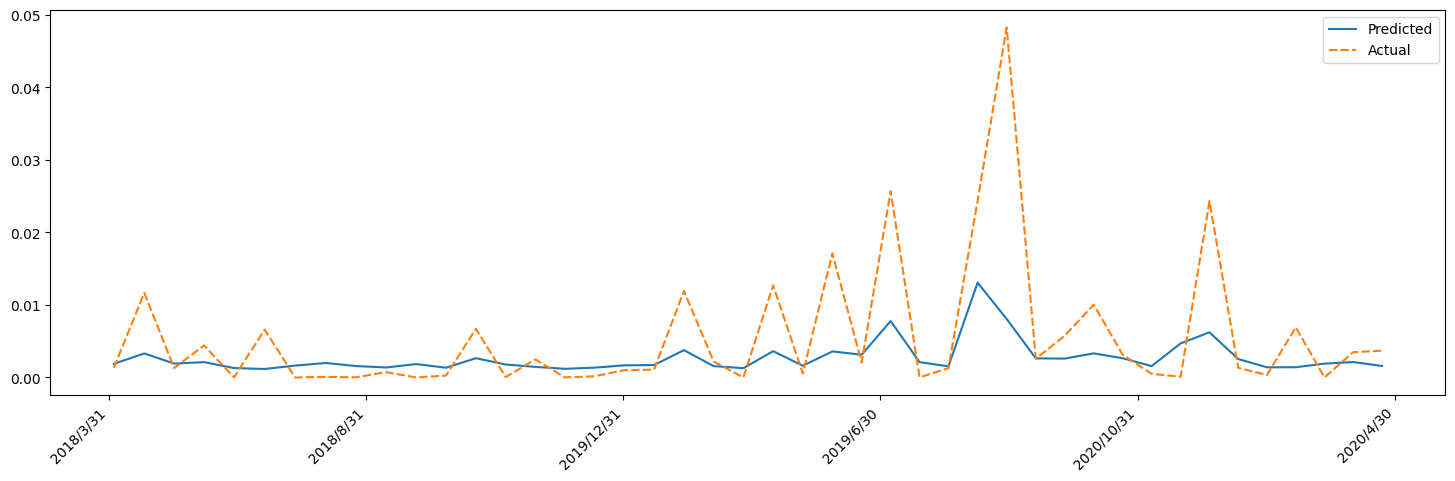

6.799162380631972e-05

In [26]:
sample_stock2 = final_data[final_data['gvkey']==4517]
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,5))
ax = sns.lineplot(data=pd.DataFrame({'Predicted':sample_stock2['prediction_decode_fix'],'Actual':sample_stock2['risk1m']}))
#ax.set_xticks(range(0, len(sample_stock2), 5))
ax.set_xticklabels(sample_stock2.date[::5], rotation=45, ha='right')
plt.show()

sample_loss = mean_squared_error(sample_stock2['prediction_decode_fix'], sample_stock2['risk1m'])
sample_loss

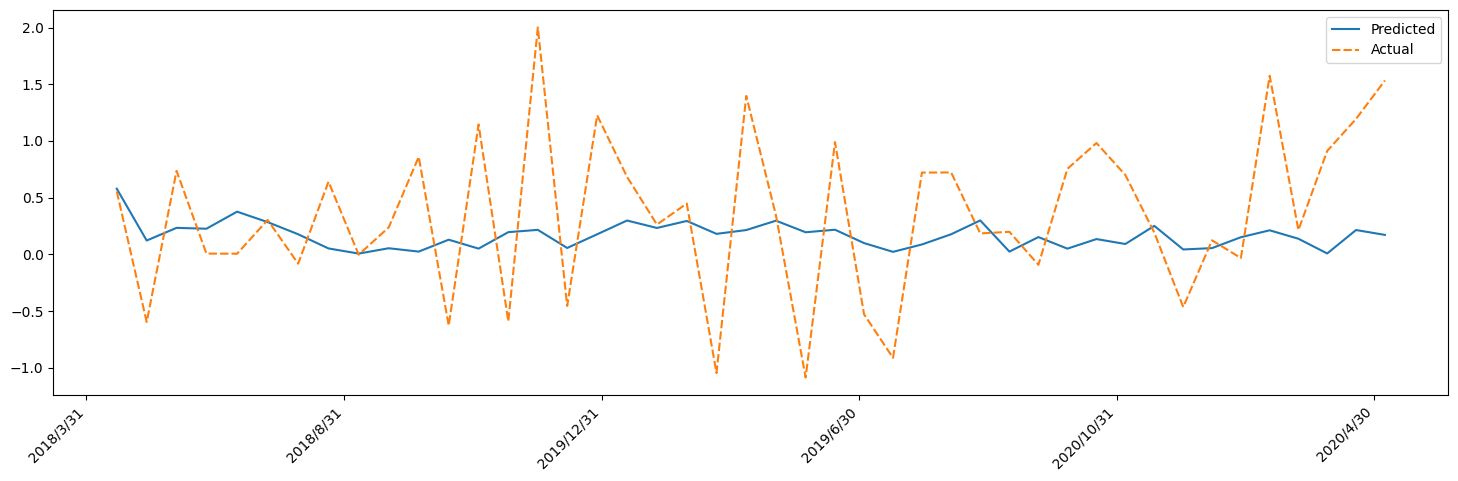

0.5413522324068553

In [62]:
sample_stock2 = final_data[final_data['gvkey']==187697]
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,5))
ax = sns.lineplot(data=pd.DataFrame({'Predicted':sample_stock2['prediction_decode_fix'],'Actual':sample_stock2['trt1m']}))
#ax.set_xticks(range(0, len(sample_stock2), 5))
ax.set_xticklabels(sample_stock2.date[::5], rotation=45, ha='right')
plt.show()

sample_loss = mean_squared_error(sample_stock2['prediction_decode_fix'], sample_stock2['trt1m'])
sample_loss

In [29]:
per_period_median_prediction = final_data.groupby('date')['prediction_decode_fix'].apply(lambda x: np.percentile(x, 50)).reset_index()
per_period_median_prediction = per_period_median_prediction.rename(columns={'prediction_decode_fix':"predict_median"})
per_period_median_actual = final_data.groupby('date')['risk1m'].apply(lambda x: np.percentile(x, 50)).reset_index()
per_period_median_actual = per_period_median_actual.rename(columns={'risk1m':"actual_median"})
data_roc2 = final_data.merge(per_period_median_prediction, on='date')
data_roc2 = data_roc2.merge(per_period_median_actual, on='date')

In [30]:
data_roc2['binary_target_1'] = data_roc2['risk1m'] >= data_roc2['actual_median']
data_roc2.binary_target_1.mean()

0.500475850582917

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(data_roc2.binary_target_1, data_roc2.prediction)

# Calculate AUC score
auc_score = roc_auc_score(data_roc2.binary_target_1, data_roc2.prediction)
print(auc_score)

0.6011221803992367


In [33]:
trainer.checkpoint_callback.best_model_path

'lightning_logs\\lightning_logs\\version_16\\checkpoints\\epoch=15-step=480.ckpt'

In [20]:
#best_model_path = trainer.checkpoint_callback.best_model_path
tft = TemporalFusionTransformer.load_from_checkpoint('epoch=15-step=480.ckpt')
tft

TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            8
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       16
  	"learning_rate":                     0.03
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"lstm_layers":                       1
  	"max_encoder_length":                24
  	"monotone_constaints":               {}
  	"opti

In [21]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = tft.predict(testing_dataloader2, mode="raw", return_x=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x3725 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

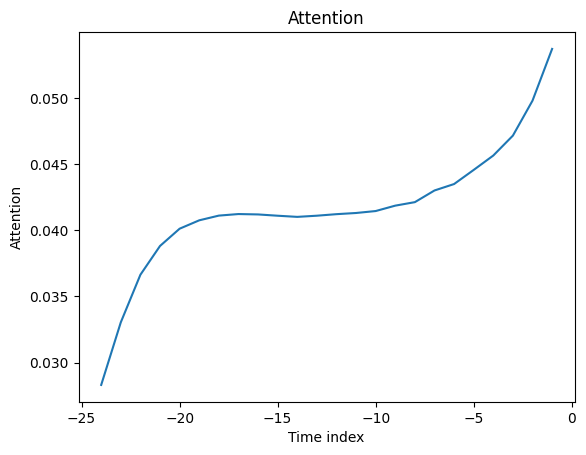

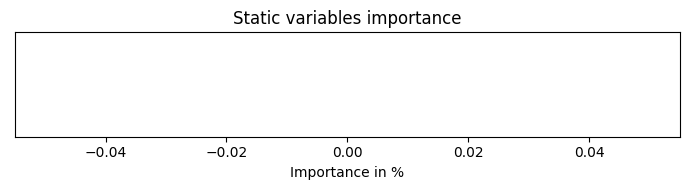

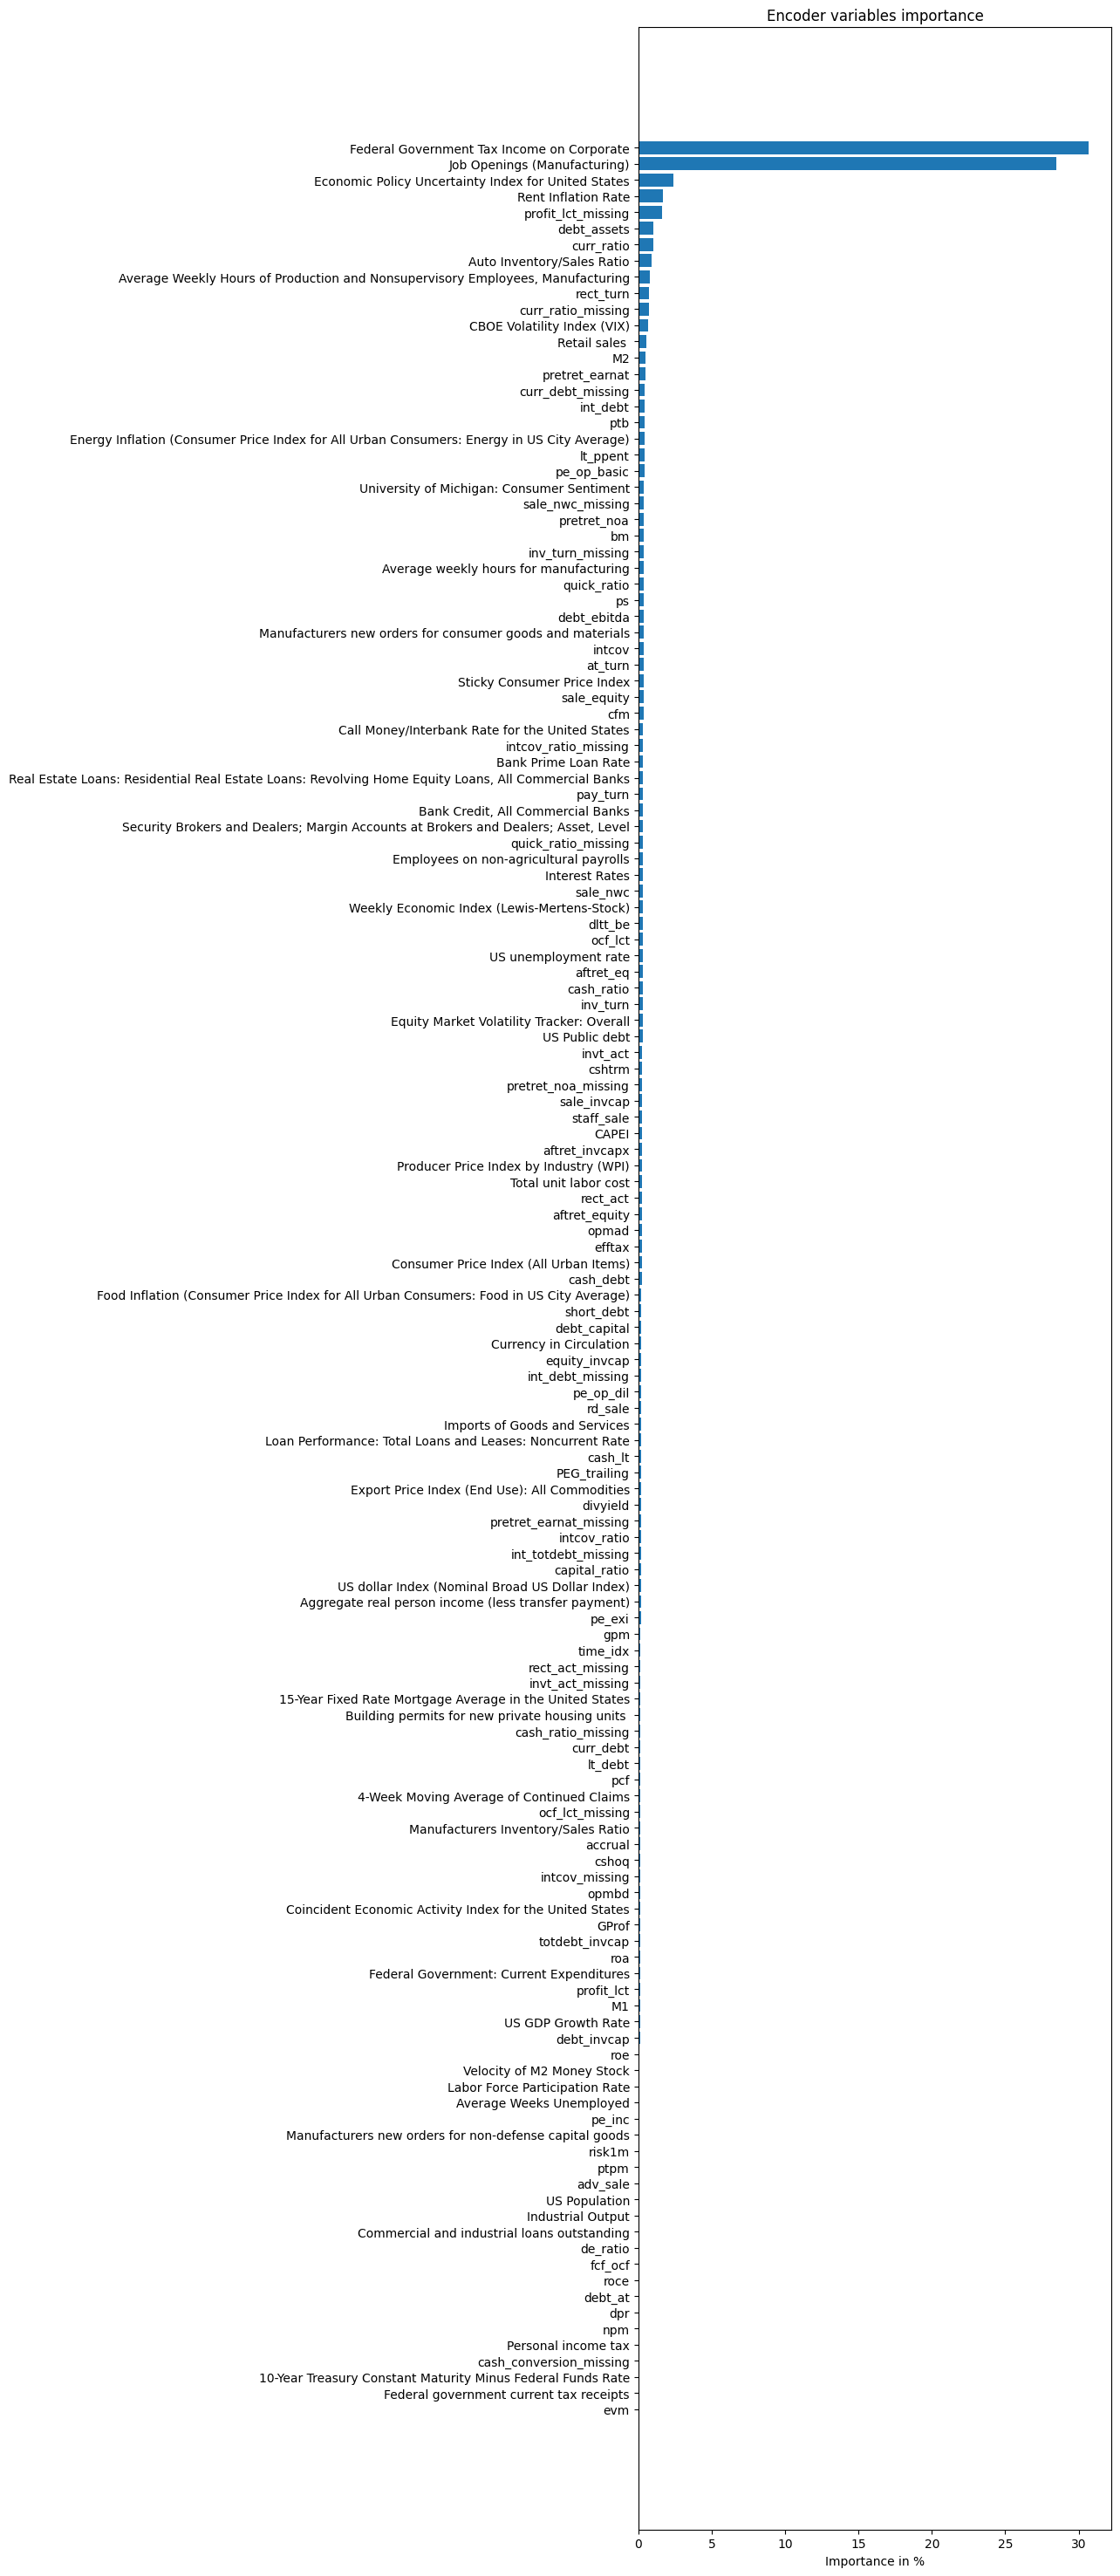

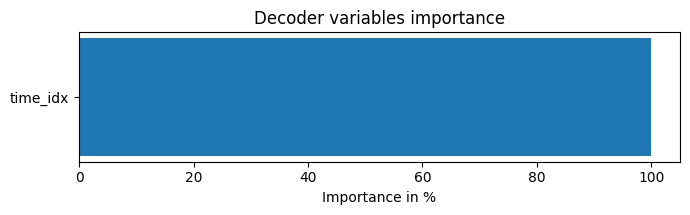

In [35]:
interpretation = tft.interpret_output(raw_predictions, reduction="sum")
tft.plot_interpretation(interpretation)

In [24]:
feature_importance = pd.DataFrame({'factor_risk1m':tft.encoder_variables, 'coefficient_risk1m':interpretation['encoder_variables']})
feature_importance = feature_importance.sort_values(by='coefficient_risk1m', ascending=False)
feature_importance

,factor_risk1m,coefficient_risk1m
132,Federal Government Tax Income on Corporate,7316.976562
122,Job Openings (Manufacturing),7311.358398
47,Economic Policy Uncertainty Index for United S...,605.933105
11,Rent Inflation Rate,444.136292
64,profit_lct_missing,421.630188
...,...,...
90,Personal income tax,12.549678
92,cash_conversion_missing,10.383441
133,10-Year Treasury Constant Maturity Minus Feder...,9.610742
119,Federal government current tax receipts,9.004874


In [ ]:
feature_importance.to_csv("TFT Risk Feature Importance.csv", index=False)

In [87]:
data_60=data_prior2014[data_prior2014['gvkey'].isin(train_set['gvkey'])]
data_40=data_prior2014[data_prior2014['gvkey'].isin(valid_set['gvkey'])]

In [88]:
gvkeys = data_60['gvkey'].unique()

# Randomly select 30 elements from the array
random_indices = np.random.choice(gvkeys.shape[0], size=100, replace=False)
samples = gvkeys[random_indices]
# Create a sub-DataFrame containing only rows where gvkeys is in selected_elements
sample_df = data_60[data_60['gvkey'].isin(samples)]

training_data_sample = TimeSeriesDataSet(
    sample_df,
    time_idx="time_idx",
    target="trt1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list,
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)

train_dataloader_sample  = training_data_sample.to_dataloader(train=True, batch_size=batch_size, num_workers=5)

In [21]:
gvkeys4 = data_40['gvkey'].unique()

# Randomly select 30 elements from the array
random_indices4 = np.random.choice(gvkeys4.shape[0], size=50, replace=False)
samples4 = gvkeys4[random_indices4]
# Create a sub-DataFrame containing only rows where gvkeys is in selected_elements
sample_df4 = data_40[data_40['gvkey'].isin(samples4)]

vali_data_sample = TimeSeriesDataSet(
    sample_df4,
    time_idx="time_idx",
    target="trt1m",
    group_ids=["gvkey"],
    time_varying_unknown_reals= col_list,
    max_encoder_length=n_time_steps,
    max_prediction_length=n_predictions,
    allow_missing_timesteps=True,
    time_varying_known_reals=["time_idx"]
)

vali_dataloader_sample  = vali_data_sample.to_dataloader(train=False, batch_size=batch_size, num_workers=5)

In [22]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader_sample,
    vali_dataloader_sample,
    model_path="optuna_test",
    n_trials=50,  
    max_epochs=20,  
    gradient_clip_val_range=(0.01, 0.1),  
    hidden_size_range=(8, 32),  
    hidden_continuous_size_range=(8, 32),  
    attention_head_size_range=(1, 2),  
    learning_rate_range=(0.001, 0.01),  
    dropout_range=(0.1, 0.2),  
    trainer_kwargs=dict(limit_train_batches=10),  
    reduce_on_plateau_patience=2,  
    use_learning_rate_finder=False, 
)

with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

print(study.best_trial.params)

[I 2023-04-12 02:58:21,851] A new study created in memory with name: no-name-2142aa9d-50c0-434e-a8b3-1e65ed41aa55
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2023-04-12 03:08:20,961] Trial 0 finished with value: 4.29507303237915 and parameters: {'gradient_clip_val': 0.015247085241691482, 'hidden_size': 9, 'dropout': 0.10734221332036537, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0026767894761904314}. Best is trial 0 with value: 4.29507303237915.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2023-04-12 03:18:43,829] Trial 1 finished with value: 4.779044151306152 and parameters: {'gradient_clip_val': 0.02114370155478029, 'hidden_size': 11, 'dropout': 0.1330

{'gradient_clip_val': 0.01272237211105487, 'hidden_size': 16, 'dropout': 0.15061087870498097, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.0025959579657758173}


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(testing_dataloader)])
predictions = best_tft.predict(testing_dataloader)
mean_squared_error(actuals,predictions)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(testing_dataloader)])
predictions = best_tft.predict(testing_dataloader)
(actuals - predictions).abs().mean()

In [10]:
tft = TemporalFusionTransformer.from_dataset(
    time_series,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
